### Load image data

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import os 
import cv2

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.svm import SVC
from tensorflow import keras
from keras.preprocessing.image import load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras import utils
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

file path did not work
file path did not work
file path did not work


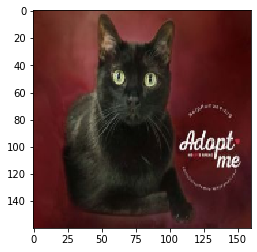

In [2]:
data = []
dirpath = "datasets/cat_imgs"
folders = ['tabby', 'siamese','bombay']
for folder in folders:
    path = os.path.join(dirpath, folder)
    for img_path in os.listdir(path):
        try: 
            image_arr = cv2.imread(os.path.join(path, img_path))
            img_rgb=cv2.cvtColor(image_arr, cv2.COLOR_BGR2RGB)
            new_array = cv2.resize(img_rgb,(160, 160))
            data.append([new_array, folders.index(folder)])
            plt.imshow(new_array)
        except:
            print("file path did not work")
        

### EDA

In [3]:
# check how many images I have 
len(data)

832

In [4]:
X = []
y = []
for feature, label in data:
    X.append(feature)
    y.append(label)

In [5]:
X = np.array(X)

In [87]:
X.shape


(832, 160, 160, 3)

In [7]:
graph_y = pd.Series(y).map({0:'orange tabby', 1:'siamese', 2: 'bombay'})

Text(0.5, 0, 'Cat breeds')

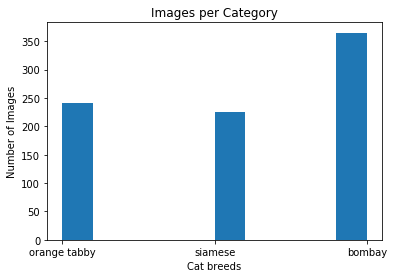

In [8]:
plt.hist(graph_y)
plt.title('Images per Category')
plt.ylabel('Number of Images')
plt.xlabel('Cat breeds')

### Feature engenierring  

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [10]:
#Normalize the scale to 0-1
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train /= 255
X_test /= 255

In [11]:
X_train.shape

(624, 160, 160, 3)

### Modeling

#### Support Vector Mechines

In [12]:
cats_train = []
for i, img in enumerate(X_train):
    train = pd.Series(img.flatten(), name = i)
    cats_train.append(train)

In [13]:
cats_test=[]
for a, each in enumerate(X_test):
    cat_test = pd.Series(each.flatten(), name = a)
    cats_test.append(cat_test)

In [14]:
np.array(cats_train).shape, np.array(cats_test).shape

((624, 76800), (208, 76800))

In [15]:
svm = SVC()

In [16]:
params = {'C': [0.01, 1],
         'kernel': ['poly', 'rbf','sigmoid']}

In [17]:
gs_svm = GridSearchCV(svm, params, cv = 3)
gs_svm.fit(cats_train, y_train)

GridSearchCV(cv=3, estimator=SVC(),
             param_grid={'C': [0.01, 1], 'kernel': ['poly', 'rbf', 'sigmoid']})

In [18]:
gs_svm.best_params_

{'C': 1, 'kernel': 'poly'}

In [19]:
svm_pred = gs_svm.predict(cats_test)

In [20]:
gs_svm.score(cats_test, y_test)

0.8269230769230769

In [32]:
gs_svm.score(cats_train , y_train)

0.9951923076923077

In [21]:
results = pd.DataFrame({'predicted': svm_pred,
                        'actual': y_test})

In [22]:
results.head()

,predicted,actual
0,2,2
1,2,2
2,1,1
3,2,2
4,0,0


In [23]:
def visual_result(i):
    name_list = ['orange tabby', 'siamese', 'bombay']
    plt.imshow(np.array(cats_test[i]).reshape(160, 160, 3),
               interpolation='nearest')
    plt.show()
    print(f'The model guessed this was: {name_list[results["predicted"].iloc[i]]}.')
    print(f'This actually is: {name_list[results["actual"].iloc[i]]}.')
    print()

In [24]:
row_inds = results[results['predicted'] != results['actual']].index

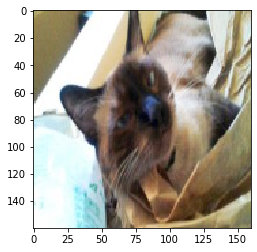

The model guessed this was: bombay.
This actually is: siamese.



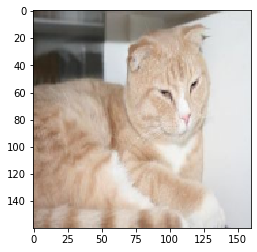

The model guessed this was: siamese.
This actually is: orange tabby.



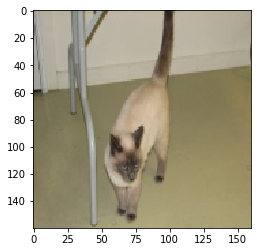

The model guessed this was: orange tabby.
This actually is: siamese.



In [91]:
#show the top 3 misclassified pictures
for index in row_inds[:3]:
    visual_result(index)

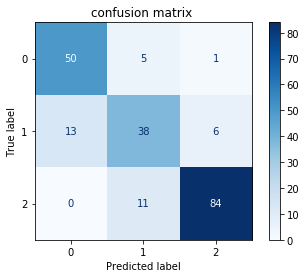

In [30]:
plot_confusion_matrix(gs_svm, cats_test, y_test, cmap = 'Blues', values_format = 'd')
plt.title('confusion matrix ');

Ref: https://git.generalassemb.ly/DSI-US-12/6.05-lesson-support-vector-machines/blob/master/starter-code-ec.ipynb

#### Convolutional Neural Network 

In [33]:
y_train = utils.to_categorical(y_train, 3)
y_test = utils.to_categorical(y_test, 3)

In [75]:
cnn_model = Sequential()

In [76]:
#first convolutional layer
cnn_model.add(Conv2D(filters=64,            
                     kernel_size=(3, 3),        
                     activation='relu',      
                     input_shape=(160, 160, 3)))
cnn_model.add(MaxPooling2D(pool_size=(2,2)))

#second convolutional layer
cnn_model.add(Conv2D(filters=128,            
                     kernel_size=(3, 3),        
                     activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2,2)))

#third convolutional layer
cnn_model.add(Conv2D(filters=128,            
                     kernel_size=(3, 3),        
                     activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2,2)))

#fourth convolutional layer
cnn_model.add(Conv2D(filters=512,            
                     kernel_size=(3, 3),        
                     activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2,2)))

#fifth  convolutional layer
cnn_model.add(Conv2D(filters=512,            
                     kernel_size=(3, 3),        
                     activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2,2)))


#flatten the metrics to fit into the Dense layers 
cnn_model.add(Flatten())

In [77]:
cnn_model.add(Dense(2048, activation = 'relu'))
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(1024, activation = 'relu'))
cnn_model.add(Dense(1024, activation = 'relu'))
cnn_model.add(Dropout(0.2))
cnn_model.add(Dense(512, activation = 'relu'))
cnn_model.add(Dropout(0.2))
cnn_model.add(Dense(512, activation = 'relu'))
cnn_model.add(Dropout(0.2))
cnn_model.add(Dense(256, activation = 'relu'))
cnn_model.add(Dropout(0.2))
cnn_model.add(Dense(128, activation = 'relu'))
cnn_model.add(Dropout(0.3))



# The final layer
cnn_model.add(Dense(3, activation = 'softmax'))

In [78]:
# Compile model
cnn_model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [79]:
# Fit model on training data
history = cnn_model.fit(X_train,
                          y_train,
                          batch_size=128,
                          validation_data=(X_test, y_test),
                          epochs=30)

Epoch 1/30
5/5 [==============================] - 11s 2s/step - loss: 1.0936 - accuracy: 0.4151 - val_loss: 1.0076 - val_accuracy: 0.4567
Epoch 2/30
5/5 [==============================] - 11s 2s/step - loss: 1.0078 - accuracy: 0.4327 - val_loss: 1.0551 - val_accuracy: 0.4567
Epoch 3/30
5/5 [==============================] - 11s 2s/step - loss: 1.1076 - accuracy: 0.4327 - val_loss: 0.9601 - val_accuracy: 0.4567
Epoch 4/30
5/5 [==============================] - 11s 2s/step - loss: 1.0208 - accuracy: 0.5337 - val_loss: 0.9792 - val_accuracy: 0.6106
Epoch 5/30
5/5 [==============================] - 11s 2s/step - loss: 0.8943 - accuracy: 0.4936 - val_loss: 0.7382 - val_accuracy: 0.6827
Epoch 6/30
5/5 [==============================] - 12s 2s/step - loss: 0.7965 - accuracy: 0.6779 - val_loss: 0.7692 - val_accuracy: 0.6875
Epoch 7/30
5/5 [==============================] - 12s 2s/step - loss: 0.7674 - accuracy: 0.6891 - val_loss: 0.7591 - val_accuracy: 0.6923
Epoch 8/30
5/5 [==================

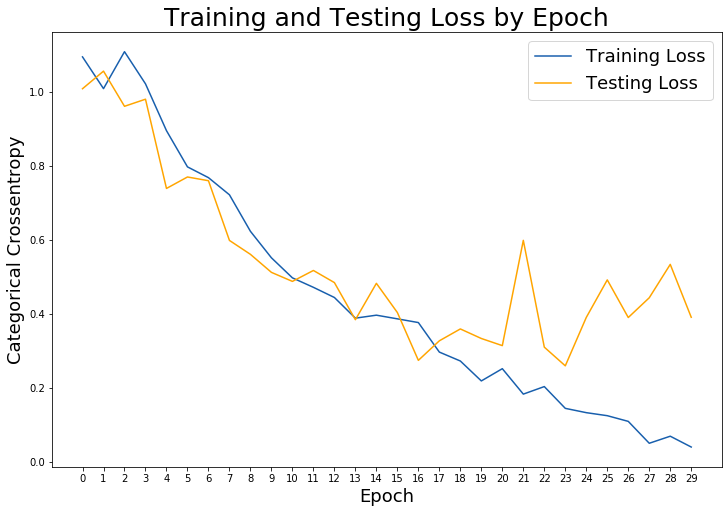

In [80]:

# Check out our train loss and test loss over epochs.
train_loss = history.history['loss']
test_loss = history.history['val_loss']
epoch_labels = history.epoch

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Loss', color='#185fad')
plt.plot(test_loss, label='Testing Loss', color='orange')

# Set title
plt.title('Training and Testing Loss by Epoch', fontsize=25)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Categorical Crossentropy', fontsize=18)
plt.xticks(epoch_labels, epoch_labels)    # ticks, labels

plt.legend(fontsize=18);

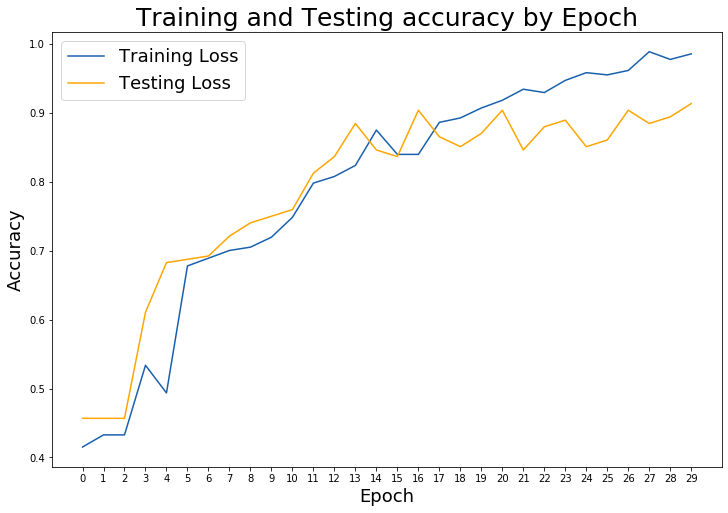

In [81]:
# Check out our train loss and test loss over epochs.
train_loss = history.history['accuracy']
test_loss = history.history['val_accuracy']
epoch_labels = history.epoch

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Loss', color='#185fad')
plt.plot(test_loss, label='Testing Loss', color='orange')

# Set title
plt.title('Training and Testing accuracy by Epoch', fontsize=25)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Accuracy', fontsize=18)
plt.xticks(epoch_labels, epoch_labels)    # ticks, labels

plt.legend(fontsize=18);

In [82]:
cnn_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_35 (Conv2D)           (None, 158, 158, 64)      1792      
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 79, 79, 64)        0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 77, 77, 128)       73856     
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 38, 38, 128)       0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 36, 36, 128)       147584    
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 18, 18, 128)       0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 16, 16, 512)      

In [85]:
cnn_model.save('cnn_model')

INFO:tensorflow:Assets written to: cnn_model/assets


In [86]:
cnn_score = cnn_model.evaluate(X_test,
                               y_test,
                               verbose=1)

cnn_labels = cnn_model.metrics_names

7/7 [==============================] - 1s 152ms/step - loss: 0.3902 - accuracy: 0.9135
